# Code for Cplex formulation of Alstom problem

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dimod import ConstrainedQuadraticModel, Binary, Real
from dwave.system import LeapHybridCQMSampler
import numpy as np
import dimod

## Approximating the functions with polynomials

### RAV function

[ 198.7 3000. ]


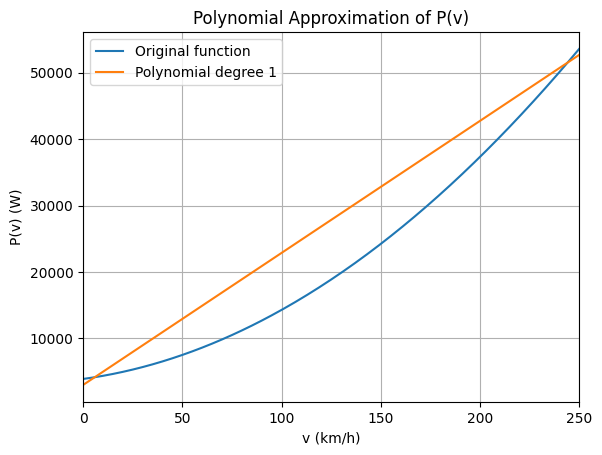

[ 198.7 3000. ]


In [2]:
A, B, C, m, v_max, p_max, c_max = 3900, 40.7, 0.632, 400000, 220, 4305220, 320000
import numpy as np


def P(v):
    return (A + B * v + C * v**2)


a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 251)
y_points_bis = []
for x in x_points:
    y_points_bis.append(P(x))

# Get the polynomial coefficients (highest degree first)
coeffs_rav = np.polyfit(x_points, y_points_bis, deg=n)
coeffs_rav[1] = 3000
# Create polynomial function
print(coeffs_rav)
Prav_poly = np.poly1d(coeffs_rav)

# Define the linear approximation of Prav_poly
def Prav_approx(v):
    return coeffs_rav[0] * v + coeffs_rav[1]



y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Prav_approx(x_points[i]))


if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.title("Polynomial Approximation of P(v)")
    plt.xlabel("v (km/h)")
    plt.ylabel("P(v) (W)")
    plt.xlim(a, b)
    plt.legend()
    plt.grid(True)
    plt.show()

print(coeffs_rav)

### Traction

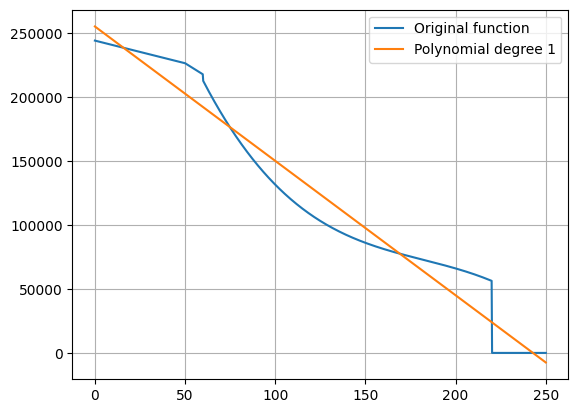

In [3]:
def f(v):
    if 0 <= v <= 50:
        return -354.1 * v + 2.44 * (10**5)
    elif 50 <= v < 60:
        return -881.3 * v + 2.704 * (10**5)
    elif 60 <= v < 220:
        return -0.05265 * (v**3) + 28.78 * (v**2) - 5603 * v + 4.566 * (10**5)
    else:
        return 0
    
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
# Create polynomial function
Ptraction = np.poly1d(coeffs)


y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Ptraction(x_points[i]))

F_pos_max = max(y_points_approx)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Braking

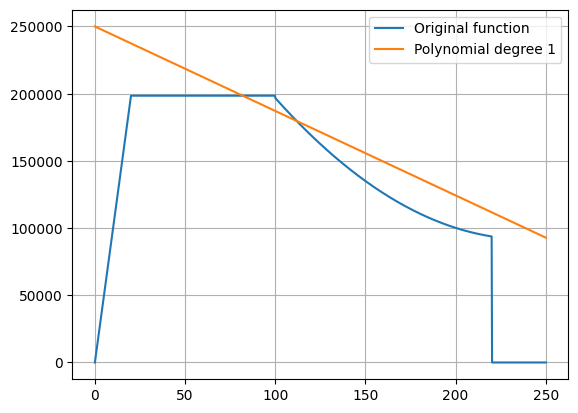

In [4]:
def f(v):
    if 0 <= v <= 20:
        return 9925 * v + 1.243
    if 20 <= v <= 100:
        return 2.039 * (10**-13) * v + 1.985 * (10**5)
    if 100 <= v <= 220:
        return 5.389 * (v**2) - 2583 * v + 4.012 * (10**5)
    else:
        return 0


# Interval [a, b] and degree n
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
coeffs[1] = 250000
# Create polynomial function
Pbraking = np.poly1d(coeffs)



y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Pbraking(x_points[i]))

F_neg_max = max(y_points_approx)
F_max = max(F_pos_max, F_neg_max)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Power usage

[-3.06727976e-17  7.13384433e-01  0.00000000e+00  2.46745051e-02]
The polynomial is: -3.0672797635133965e-17 + 0.7133844326798683*x + 0.0*y + 0.024674505091040206*x*y


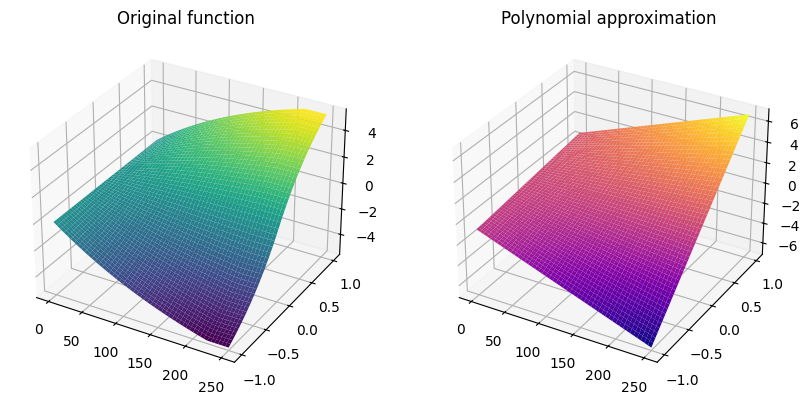

In [5]:
def cost(V, demand):
    F_max = 1
    V_max = 220
    F = demand
    p_max = 4305220
    c_max = 320000
    V_safe = min(V, V_max)
    # Ensure V is within a safe range for math.exp
    c = (
        (1 - math.exp(-V_safe / (V_max + 0.001)))
        * math.tanh(100 * F)
        * (1 - math.exp(-abs(F) / (F_max + 0.001)))
    )
    Puti = (c / c_max) * p_max
    # For now we ignore regen braking
    '''if Puti < 0:
        Puti = 0
    elif Puti > p_max:
        Puti = p_max'''
    return Puti


# Define the domain
a_x, b_x = 0, 250
a_y, b_y = -1, 1
n = 1  # degree in x
l = 1  # degree in y

# Create the interpolation points (equally spaced)
x_points = np.linspace(a_x, b_x, 1000)
y_points = np.linspace(a_y, b_y, 1000)
X, Y = np.meshgrid(x_points, y_points, indexing="ij")
Z = np.eye(1000)
for i in range(len(x_points)):
    for j in range(len(y_points)):
        x = x_points[i]
        y = y_points[j]
        Z[i, j] = cost(x, y)


# Build the Vandermonde matrix for 2D
x_flat = X.ravel()
y_flat = Y.ravel()

A = np.vstack([(x_flat**i) * (y_flat**j) for i in range(n + 1) for j in range(l + 1)]).T

b = Z.ravel()
coeffs_pow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(coeffs_pow)
print(f"The polynomial is: {coeffs_pow[0]} + {coeffs_pow[1]}*x + {coeffs_pow[2]}*y + {coeffs_pow[3]}*x*y")


# Define the polynomial function
def Ppower(x, y):
    val = 0
    idx = 0
    for i in range(n + 1):
        for j in range(l + 1):
            val += coeffs_pow[idx] * (x**i) * (y**j)
            idx += 1
    return val


# Evaluation grid
x_eval = x_points
y_eval = y_points
X_eval, Y_eval = np.meshgrid(x_eval, y_eval, indexing="ij")
Z_eval = Ppower(X_eval, Y_eval)

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X_eval, Y_eval, Z, cmap="viridis")
ax.set_title("Original function")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X_eval, Y_eval, Z_eval, cmap="plasma")
ax2.set_title("Polynomial approximation")

plt.show()

Text(0.5, 1.0, 'Max acceleration at constant power vs Speed')

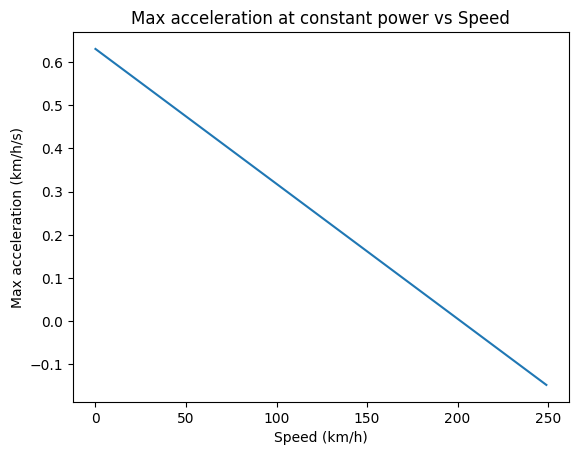

In [6]:
# Testing speed at constant maximum power
v = np.arange(0, 250, 1)
max_acceration = []
for speed in v:
    acc = (Ptraction(speed)-Prav_poly(speed)) / m
    max_acceration.append(acc)


plt.plot(v, max_acceration, label="Max acceleration at constant power")
plt.xlabel("Speed (km/h)")
plt.ylabel("Max acceleration (km/h/s)")
plt.title("Max acceleration at constant power vs Speed")

## Defining the Model

### Define model

In [7]:
cqm = ConstrainedQuadraticModel()
N = 10
Dist = 0.05
dt = 6 #seconds

### Define variables

In [8]:
v={}
for i in range(0, N):
    v[i]= Real(f"v_{i}",lower_bound=0, upper_bound=v_max)

d={}
for i in range(0, N):
    d[i]= Real(f"d_{i}",lower_bound=0, upper_bound=2)


cqm.add_constraint(d[0]>=1.0)

'c1a266a'

### Cost function

#### Linearization

In [9]:
# Here we linearize the D*v part of the polynomial approximation of our cost function

w1 = {}
for i in range(0, N):
    w1[i] = Real(f"w1_{i}",lower_bound=0,upper_bound=2*v_max)

V_min, V_max = 0, 250
d_min, d_max = 0,2

# coefficients from polynomial fit of cost function (Power consumption)
c0, c1, c2, c3 = coeffs_pow

for i in range(0, N):
    '''cqm.add_constraint(w1[i] - d_min * v[i] - (d[i] - 1) * V_min + V_min * d_min  >= 0, label=f"Constraint_1_{i}")
    cqm.add_constraint(w1[i] - (d_max * v[i] + (d[i] - 1) * V_max - V_max * d_max) >= 0, label=f"Constraint_2_{i}")
    cqm.add_constraint(w1[i] - (d_max * v[i] + (d[i] - 1) * V_min - d_max * V_min) <= 0, label=f"Constraint_3_{i}")
    cqm.add_constraint(w1[i] - (d_min * v[i] + (d[i] - 1) * V_max - d_min * V_max) <= 0, label=f"Constraint_4_{i}")'''

    cqm.add_constraint(w1[i]  >= 0, label=f"Constraint_1_{i}")
    cqm.add_constraint(w1[i] - (d_max * v[i] + d[i] * V_max - V_max * d_max) >= 0, label=f"Constraint_2_{i}")
    cqm.add_constraint(w1[i] - (d_max * v[i]) <= 0, label=f"Constraint_3_{i}")
    cqm.add_constraint(w1[i] - (d[i] * V_max) <= 0, label=f"Constraint_4_{i}")

#### Definition

In [10]:
# Total cost
total_cost = sum(c0 + c1 * v[i] + c2 * (d[i]-1) + c3 * (w1[i]-v[i]) for i in range(N))
cqm.set_objective(total_cost)

### Speed physics constraints (there is a problem somewhere in here)

#### Linearising

In [11]:
# Define binary variables for delta
delta = {}
for i in range(0, N):
    delta[i] = Binary(f"delta_{i}")

# Define constants
epsilon = 1e-9

# Add constraints to the cqm
for i in range(0, N):
    '''cqm.add_constraint((d[i] - 1) - epsilon + (1 - delta[i]) <= 0, label=f"Delta_Constraint_1_{i}")'''

    cqm.add_constraint((d[i] - 1) + epsilon + (1 - delta[i]) >= 0, label=f"Delta_Constraint_1_{i}")
    cqm.add_constraint((d[i] - 1) - delta[i] <= 0, label=f"Delta_Constraint_2_{i}")

In [12]:
# Fit linear approximations to Ptraction and Pbraking
Ptraction_linear = np.polyfit(np.linspace(0, v_max, 100), [Ptraction(v) for v in np.linspace(0, v_max, 100)], 1)
Pbraking_linear = np.polyfit(np.linspace(0, v_max, 100), [Pbraking(v) for v in np.linspace(0, v_max, 100)], 1)

# Initialize z1 and z2
z1 = {}
z2 = {}
for i in range(0, N):
    z1[i] = Real(f"z1_{i}", lower_bound=0, upper_bound=F_max)
    z2[i] = Real(f"z2_{i}", lower_bound=0, upper_bound=F_max)

L1 = 0.0
L2 = 0.0
U1 = F_max
U2 = F_max

# Define linearized functions
def Ptraction_approx(v):
    return Ptraction_linear[0] * v + Ptraction_linear[1]

def Pbraking_approx(v):
    return Pbraking_linear[0] * v + Pbraking_linear[1]

# Update constraints to use linearized functions
for i in range(0, N):
    '''cqm.add_constraint(z1[i] - (Ptraction_approx(v[i])) + L1 * (1 - delta[i]) <= 0, label=f"Z1_Ptraction_{i}")
    cqm.add_constraint(z2[i] - (Pbraking_approx(v[i])) - L2 * delta[i] <= 0, label=f"Z2_Pbraking_{i}")
    cqm.add_constraint(z1[i] - (Ptraction_approx(v[i])) + U1 * (1 - delta[i]) >= 0, label=f"Z1_Ptraction_Lower_{i}")
    cqm.add_constraint(z2[i] - (Pbraking_approx(v[i])) + U2 * delta[i] >= 0, label=f"Z2_Pbraking_Lower_{i}")'''
    

    cqm.add_constraint(z1[i] - delta[i]*U1 <= 0, label=f"Z1_Ptraction_Upper_{i}")
    cqm.add_constraint(z2[i] - (1-delta[i])*U2 <= 0, label=f"Z2_Pbraking_Upper_{i}")

    cqm.add_constraint(z1[i] - (Ptraction_approx(v[i])) <= 0, label=f"Z1_Ptraction_{i}")
    cqm.add_constraint(z2[i] - (Pbraking_approx(v[i])) <= 0, label=f"Z2_Pbraking_{i}")

    cqm.add_constraint(z1[i] - (Ptraction_approx(v[i])) + U1 * (1 - delta[i]) >= 0, label=f"Z1_Ptraction_Lower_{i}")
    cqm.add_constraint(z2[i] - (Pbraking_approx(v[i])) + U2 * delta[i] >= 0, label=f"Z2_Pbraking_Lower_{i}")

In [13]:
# Define and linearize w2 = D * (z1 + z2)
w2 = {}
for i in range(0, N):
    w2[i] = Real(f"w2_{i}", lower_bound=0, upper_bound=2 * F_max)

# Define constants
dL, dU = 0, 2
zL, zU = 0, F_max

# Add constraints to the cqm
for i in range(0, N):
    '''cqm.add_constraint(w2[i] - dL * (z1[i] + z2[i]) - zL * (d[i]) + dL * zL >= 0, label=f"W2_Lower_Bound_1_{i}")
    cqm.add_constraint(w2[i] - dU * (z1[i] + z2[i]) - zU * (d[i]) + dU * zU >= 0, label=f"W2_Lower_Bound_2_{i}")
    cqm.add_constraint(w2[i] - dU * (z1[i] + z2[i]) - zL * (d[i]) + dU * zL <=0, label=f"W2_Upper_Bound_1_{i}")
    cqm.add_constraint(w2[i] - dL * (z1[i] + z2[i]) - zU * (d[i]) + dL * zU <=0, label=f"W2_Upper_Bound_2_{i}")'''

    cqm.add_constraint(w2[i] >= 0, label=f"W2_Lower_Bound_1_{i}")
    cqm.add_constraint(w2[i] - dU * (z1[i] + z2[i]) - zU * (d[i]) + dU * zU >= 0, label=f"W2_Lower_Bound_2_{i}")
    cqm.add_constraint(w2[i] - dU * (z1[i] + z2[i]) <=0, label=f"W2_Upper_Bound_1_{i}")
    cqm.add_constraint(w2[i]- zU * (d[i]) <=0, label=f"W2_Upper_Bound_2_{i}")

#### Definition

In [14]:
# Define the final speed constraints for D-Wave CQM
for i in range(0, N - 1):
    # Linearize the acceleration constraint
    cqm.add_constraint(
        v[i + 1] - v[i] - (dt / m) * (w2[i] - (z1[i] + z2[i]) - Prav_approx(v[i])) == 0,
        label=f"Velocity_Constraint_{i}"
    )

    # Ensure that acceleration is negative when braking
    cqm.add_constraint(
        v[i + 1] - v[i] + 0.001 - 1.001 * delta[i] <= 0,
        label=f"Acc_Implication_{i}"
    )

    # Ensure that acceleration does not exceed a maximum value
    cqm.add_constraint(
        v[i + 1] - v[i] -1  <= 0,
        label=f"Max_Acceleration_{i}"
    )

In [15]:
# Additional constraints for speed
epsilon = 0.2
cqm.add_constraint(v[0] == 0, "Initial velocity")
cqm.add_constraint(v[N-1] - epsilon<= 0, "Final velocity")

# Just to make sure
'''for i in range(0, N):
    cqm.add_constraint(v[i]>= 0, f"Velocity non-negativity {i}")'''

'for i in range(0, N):\n    cqm.add_constraint(v[i]>= 0, f"Velocity non-negativity {i}")'

## Distance constraints

In [16]:
# Add a distance constraint to ensure the train will start moving
Distance = 0
for i in range(0, N):
    Distance += v[i]*dt/3600

cqm.add_constraint(Distance >= Dist, "Total distance constraint")

'Total distance constraint'

## Problem Verification

In [17]:
# Print info on the model

# Number of variables
print(cqm.num_variables)

# Number of constraints
cqm.num_constraints

# Objective function (as a QuadraticModel)
cqm.objective

<bound method cyConstrainedQuadraticModel.num_variables of <dimod.constrained.constrained.ConstrainedQuadraticModel object at 0x7c66370071c0>>


ObjectiveView({'v_0': 0.6887099275888281, 'd_0': 0.0, 'w1_0': 0.024674505091040206, 'v_1': 0.6887099275888281, 'd_1': 0.0, 'w1_1': 0.024674505091040206, 'v_2': 0.6887099275888281, 'd_2': 0.0, 'w1_2': 0.024674505091040206, 'v_3': 0.6887099275888281, 'd_3': 0.0, 'w1_3': 0.024674505091040206, 'v_4': 0.6887099275888281, 'd_4': 0.0, 'w1_4': 0.024674505091040206, 'v_5': 0.6887099275888281, 'd_5': 0.0, 'w1_5': 0.024674505091040206, 'v_6': 0.6887099275888281, 'd_6': 0.0, 'w1_6': 0.024674505091040206, 'v_7': 0.6887099275888281, 'd_7': 0.0, 'w1_7': 0.024674505091040206, 'v_8': 0.6887099275888281, 'd_8': 0.0, 'w1_8': 0.024674505091040206, 'v_9': 0.6887099275888281, 'd_9': 0.0, 'w1_9': 0.024674505091040206}, {}, -3.067279763513396e-16, {'v_0': 'REAL', 'd_0': 'REAL', 'w1_0': 'REAL', 'v_1': 'REAL', 'd_1': 'REAL', 'w1_1': 'REAL', 'v_2': 'REAL', 'd_2': 'REAL', 'w1_2': 'REAL', 'v_3': 'REAL', 'd_3': 'REAL', 'w1_3': 'REAL', 'v_4': 'REAL', 'd_4': 'REAL', 'w1_4': 'REAL', 'v_5': 'REAL', 'd_5': 'REAL', 'w1_5

## Solving

In [18]:
# Solve the CQM using the Leap Hybrid CQM Solver
sampler = LeapHybridCQMSampler()
result = sampler.sample_cqm(cqm)

In [19]:
# Check if a feasible solution was found
if result.first.sample is not None:
    print("Feasible solution found!")
    v_sol = [result.first.sample[f"v_{i}"] for i in range(N)]
    d_sol = [result.first.sample[f"d_{i}"] - 1 for i in range(N)]
    delta_sol = [result.first.sample[f"delta_{i}"] for i in range(N)]
    print("Velocity:", v_sol)
    print("Demand:", d_sol)
    print("Delta:", delta_sol)
else:
    print("No feasible solution found.")

Dists = []
for i in range(0, N):
    Dists.append(sum(v_sol[:i])/3600)

Feasible solution found!
Velocity: [np.float64(0.0), np.float64(0.13580875046790153), np.float64(0.09040397248713199), np.float64(0.09040397248713199), np.float64(0.045134523447134096), np.float64(0.18134926194312082), np.float64(0.09040397248701854), np.float64(0.09040397248712977), np.float64(0.045134523447131876), np.float64(0.0)]
Demand: [np.float64(0.0), np.float64(-9.999999717180685e-10), np.float64(-0.5745411968948471), np.float64(0.9992767682201027), np.float64(-9.999999717180685e-10), np.float64(-1.0), np.float64(-9.999999717180685e-10), np.float64(0.9992555760495785), np.float64(0.9996283435415438), np.float64(-1.0)]
Delta: [np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.0)]


## Visualization

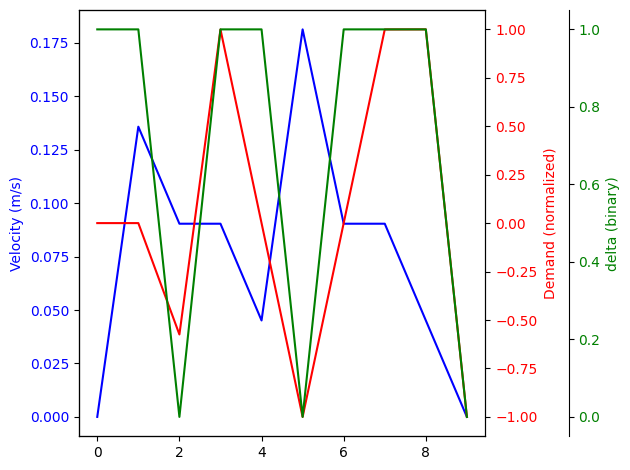

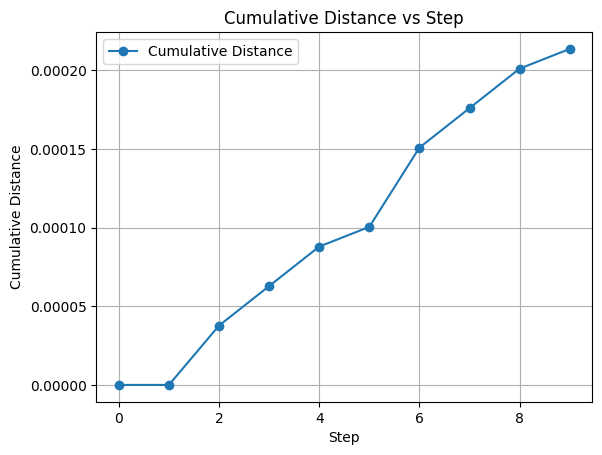

In [20]:
fig, ax1 = plt.subplots()

ax1.plot(v_sol, 'b-', label='Velocity (m/s)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(d_sol, 'r-', label='Demand (normalized)')
ax2.set_ylabel('Demand (normalized)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(delta_sol, 'g-', label='delta (binary)')
ax3.set_ylabel('delta (binary)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

# Plot Dists vs index
plt.figure()
plt.plot(Dists, marker='o', label='Cumulative Distance')
plt.xlabel('Step')
plt.ylabel('Cumulative Distance')
plt.title('Cumulative Distance vs Step')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
df = pd.DataFrame({
    'Step': range(len(v_sol)),
    'Speed': v_sol,
    'Normalized Demand': d_sol,
    'Delta Indicator': delta_sol
})

df

,Step,Speed,Normalized Demand,Delta Indicator
0,0,0.000000,0.000000e+00,1.0
1,1,0.135809,-1.000000e-09,1.0
2,2,0.090404,-5.745412e-01,0.0
3,3,0.090404,9.992768e-01,1.0
4,4,0.045135,-1.000000e-09,1.0
5,5,0.181349,-1.000000e+00,0.0
6,6,0.090404,-1.000000e-09,1.0
7,7,0.090404,9.992556e-01,1.0
8,8,0.045135,9.996283e-01,1.0
9,9,0.000000,-1.000000e+00,0.0
